## Nutritional information from openfoodfacts

In [1]:
import requests, six
import lxml.html as lh
from itertools import cycle, islice
from matplotlib import colors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline
import openfoodfacts

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("energy_tracker.db")
sugg_df = pd.read_sql_query("SELECT * from suggested_energy_intake", con)

# Verify that result of SQL query is stored in the dataframe
display(sugg_df.head(1))

sugg_df["Daily requirements"]=sugg_df["Daily requirements"].astype(float)
_ = sugg_df.rename({"Daily requirements": "amount"}, inplace=True, axis=1)

con.close()

,Nutrient,Daily requirements,Units
0,Calorie,1500.0,kcal


In [5]:
barcodes = pd.read_csv("Scan session.csv", header=None).T.to_numpy().tolist()[0]
np.savetxt("food_barcodes.csv", barcodes + [5411188512271, 8718403014549], delimiter=",", fmt='%s')
barcodes = pd.read_csv("food_barcodes.csv", header=None).T.to_numpy().tolist()[0]

In [6]:
np.array(barcodes)

array([8714779001053, 8718452427512, 8711852200181, 5411188111252,
       7394376616419, 8718452265732, 8718452459698, 5202390019319,
       8714779003187, 8718452451043, 8719324157025, 8710624281052,
       8710624280499, 8710624280437, 5060072970019, 8711299021738,
       8711299021776, 8711299021721, 8711299021714,      50818853,
       8718452334827, 8718452261697, 8713965500189, 8718452375783,
       8710398517388, 8690661080330, 8719153025236, 8718452396535,
       8718452469352, 8719189108200, 8715700131207, 8718452469352,
       8718452375783, 8713965500189, 8690661080330, 8718452459698,
       8718452459698, 5411188111078, 8719153025236, 8710398517388,
       8718692781863, 8710861912900, 5411188512271, 8718403014549])

In [7]:
all_foods_df = pd.DataFrame()
failed_barcodes = list()
for barcode_int in barcodes:
    barcode=str(barcode_int)
    try:
        search_result = openfoodfacts.products.get_product(barcode)
        food_df = pd.concat([pd.DataFrame({"product_name":search_result["product"]["product_name"],
                                          "barcode":barcode}, index=[0]), 
                         pd.DataFrame(search_result["product"]["nutriments"], index=[0])], axis=1)
        all_foods_df = pd.concat([all_foods_df, food_df])
    except:
        print(f"Barcode == {barcode} not available in the database")
        failed_barcodes.append(barcode_int)
_ = all_foods_df.reset_index(inplace=True, drop=True)

Barcode == 8718452396535 not available in the database
Barcode == 8719189108200 not available in the database


In [8]:
all_foods_df.filter(regex="100g").drop("energy_100g", axis=1).head(1)

,fat_100g,nutrition-score-fr_100g,sugars_100g,carbohydrates_100g,energy-kcal_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,saturated-fat_100g,sodium_100g,proteins_100g,fiber_100g,nova-group_100g,carbon-footprint-from-known-ingredients_100g,vitamin-k_100g,energy-kj_100g,vitamin-e_100g,magnesium_100g,vitamin-pp_100g,biotin_100g,phosphorus_100g,vitamin-b9_100g,vitamin-b12_100g,calcium_100g,vitamin-d_100g,vitamin-b2_100g
0,9.7,3.0,6.6,24.8,232,1.2,0.0,0.9,0.48,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


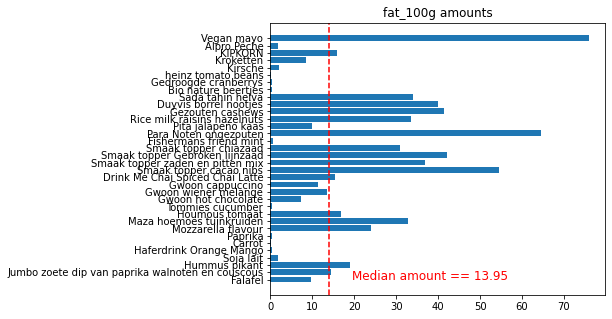

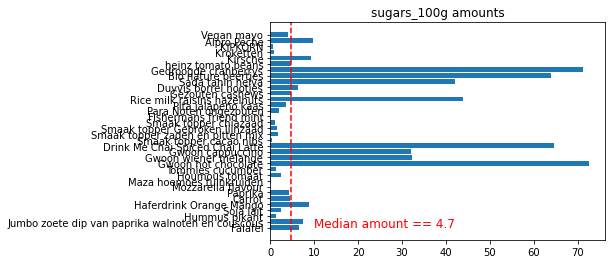

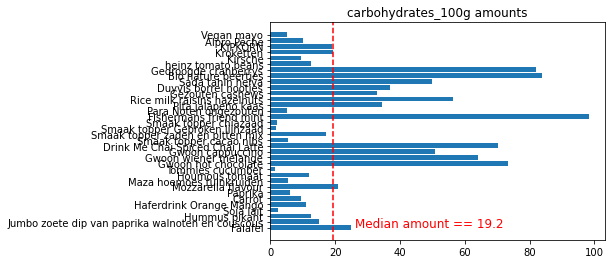

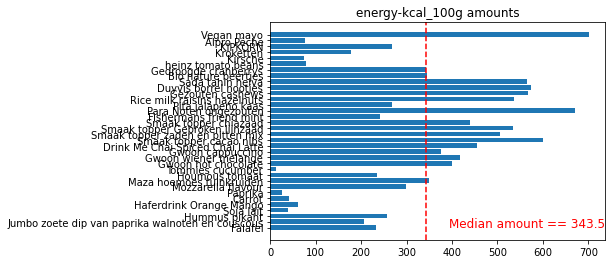

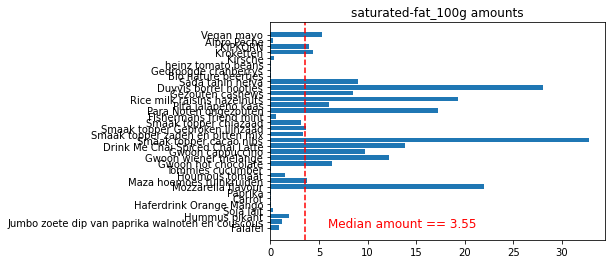

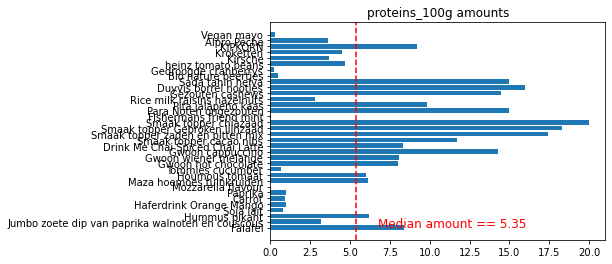

In [9]:
_ = plt.figure(figsize=(6, 5))
for colname in all_foods_df.filter(regex="100g").drop("energy_100g", axis=1).dropna(axis=1).columns.tolist():
    _ = plt.barh(all_foods_df["product_name"], all_foods_df[colname])
    _ = plt.axvline(all_foods_df[colname].median(), color="red", linestyle="--")
    _ = plt.text(x=all_foods_df[colname].median()+all_foods_df[colname].describe()["max"]/14,
                 y=0,
                 s=f'Median amount == {all_foods_df[colname].median().round(2)}',color="red", fontsize=12)
    _ = plt.title(f"{colname} amounts")
    _ = plt.show()

In [10]:
sugg_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Nutrient,Calorie,Total fat,Saturated fat,Carbohydrate,Total sugars,Salt,Protein,Fluids,Fibre,Vitamin A,Thiamin,Riboflavin,Niacin,Vitamin B6,Vitamin B12,Folate,Vitamin C,Calcium,Iodine,Iron,Magnesium,Potassium,Sodium,Zinc
amount,1500,70,20,260,90,6,64,2.3,30,900,1.2,1.3,16,1.3,2.4,400,45,1000,150,8,400,3800,920,14
Units,kcal,g,g,g,g,g,g,L,g,μg,mg,mg,mg,mg,μg,μg,mg,mg,μg,mg,mg,mg,mg,mg


In [11]:
def unit_conversion(amount, unit):
    if unit == "mg":
        return amount / 1000
    elif unit == "μg":
        return amount / 100000
    else:
        return amount

In [12]:
sugg_df["converted_amount"] = sugg_df.apply(lambda row: unit_conversion(row['amount'], row['Units']), axis=1)

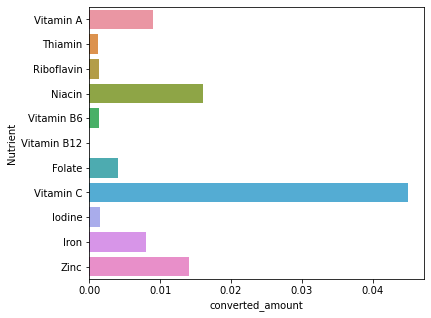

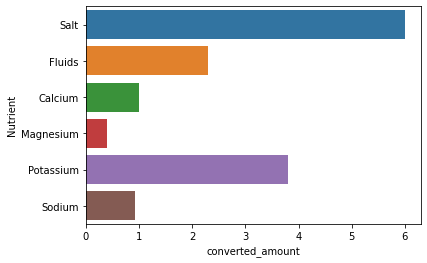

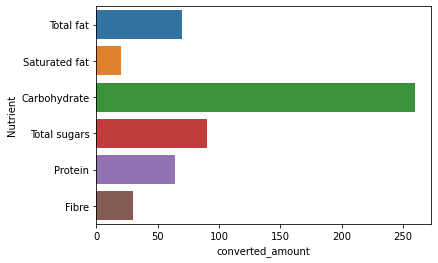

In [13]:
plt.figure(figsize=(6,5))
for i, j in [0, 0.1], [0.1, 10], [10, 300]:
    _ = sns.barplot(data=sugg_df[sugg_df["converted_amount"].between(i, j)], x="converted_amount", y="Nutrient")
    _ = plt.show()

In [ ]:
# (markers, stemlines, baseline) = plt.stem(all_foods_df.index, all_foods_df["energy-kcal"])
# _ = plt.setp(markers, marker='D', markersize=6, markeredgecolor="orange", markeredgewidth=2)
# _ = plt.axhline(all_foods_df["energy-kcal"].median(), color="red", linestyle="--")
# _ = plt.ylabel("Kcal")

In [ ]:
stop!

### upload csv to sql table

In [ ]:
# # Read sqlite query results into a pandas DataFrame
# conn = sqlite3.connect("energy_tracker.db")
# df = pd.read_csv("Suggested_nutritional_intake.csv",sep=';',quotechar='\'',encoding='utf8') # Replace Excel_file_name with your excel sheet name
# df.to_sql('suggested_energy_intake_v2',con=con,index=False,if_exists='append') # Replace Table_name with your sql table name